<p> manually set node 6-9 as full opening </p>
<p> change dt from 0.015s to 0.01s (less than 0.015s, 0.012s also works,try now), which always works</p>
<p> Courant Number = 0.54 for dt=0.012s, =0.675 for dt=0.015s, more than 0.675 does not work</p>
<p> Increase inflow means decreasing dt </p>

In [1]:
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from writeit import *
import pickle
import time
#from __future__ import division 

Populating the interactive namespace from numpy and matplotlib


In [2]:
fi = "../indata/Model2/Model2_Epipe_new.inp"    
fc = "../indata/Model2/Model2_Epipe_new.config" 
mtype=1
n1=PyNetwork(fi,fc,mtype)

In [3]:
'''
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np= shape(conns) [0]
plotNetworkLayout (xs, ys, conns, ls, Np) 
n1.showLayout() 
'''

'\n(xs,ys,conns,ls) = getBasicConnectivity(fi)\nNp= shape(conns) [0]\nplotNetworkLayout (xs, ys, conns, ls, Np) \nn1.showLayout() \n'

In [4]:
v = 0.6
Q_in = n1.Ds[0]**2*pi/4*v
n1.setbVal(0,Q_in*np.ones(n1.M+1))
jt = n1.nodeTypes
n1.setbVal(5,n1.Ds[4]*np.ones(n1.M+1))
dt = n1.T/n1.M  
print dt

0.012


In [5]:
V0 = n1.getTotalVolume()                 
n1.runForwardProblem(dt) 
V1= n1.getTotalVolume()
print "The total run time is %f s, the total volume change is %f %f cubic meters" %(n1.solve_time, V1,V0)

The total run time is 326.255966 s, the total volume change is 35.655231 0.019358 cubic meters


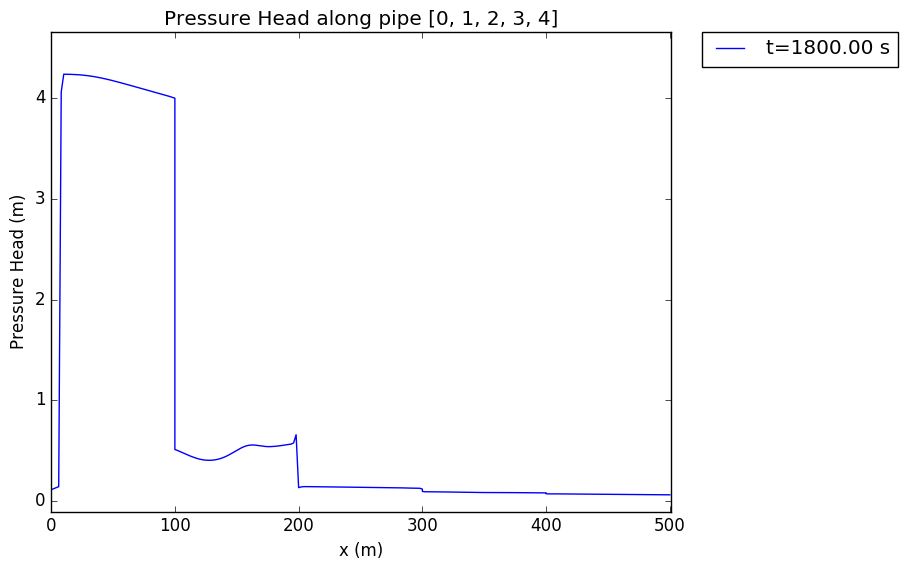

In [6]:
# Pressure Head of Pipe_interest changes with time, dynamic picture
%matplotlib notebook
#%matplotlib nbagg
import pylab as pl
from IPython import display
plt.ion()
plt.show()

pipe_interest=[0,1,2,3,4]

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length,pipe_length+n1.Ls[j],n1.Ns[j])
    x_interest.append(x)
    pipe_length=pipe_length+n1.Ls[j]

# create H_interest which stores all the pressure head data corresponding to x

# H_interest_tfixed = [Hx1,Hx2,...,Hxj], pressure head at a certain time along all interesting pipes

# H_interested =n [H_interested1, H_interested2,..., H_interestedT], H_interested[i] =  fixed time step at i*Mi_draw
# dthen get ata from H_interested_tfixed

H_interest=[]
Mi_draw=1000   # difne how many steps to skip
M_total=n1.M+1
x_interest_combine = np.concatenate(x_interest,axis =0)
for m in range(0,M_total,Mi_draw) :  
    H_interest_tfixed=[]
    for j in pipe_interest:    
        Hx = n1.pressureSpaceSeries(j,m)  
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    #plt.figure(figsize= (15,5))    #plot on different figures
    H_interest_combine = np.concatenate(H_interest[int(m/Mi_draw)],axis =0)
    pl.clf()
    figsize= (15,5)               #plot on the same figure
    pl.plot(x_interest_combine,H_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    # m is time step, and should divide m/Mi_draw to get what we need
    xlabel('x (m)')        
    ylabel('Pressure Head (m)')
    xlim(0,x_interest[-1][-1]+1)
    Hmax=max(H_interest_combine)
    #ylim(-0.1,12)
    ylim(-0.1,1.1*Hmax)
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Pressure Head along pipe %s'%str(pipe_interest)) 
    display.display(pl.gcf())
    display.clear_output(wait=True)
    #time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')


In [7]:
A_pipe=[]
for i in range(len(pipe_interest)):
    pipe_number=pipe_interest[i]
    A_pipe.append(n1.Ds[pipe_number]**2/4*pi)
    print 'pipe %d cross sectional area: A=%.4f m^2'%(pipe_number,A_pipe[i])

pipe 0 cross sectional area: A=0.0707 m^2
pipe 1 cross sectional area: A=0.0707 m^2
pipe 2 cross sectional area: A=0.0707 m^2
pipe 3 cross sectional area: A=0.0707 m^2
pipe 4 cross sectional area: A=0.0707 m^2


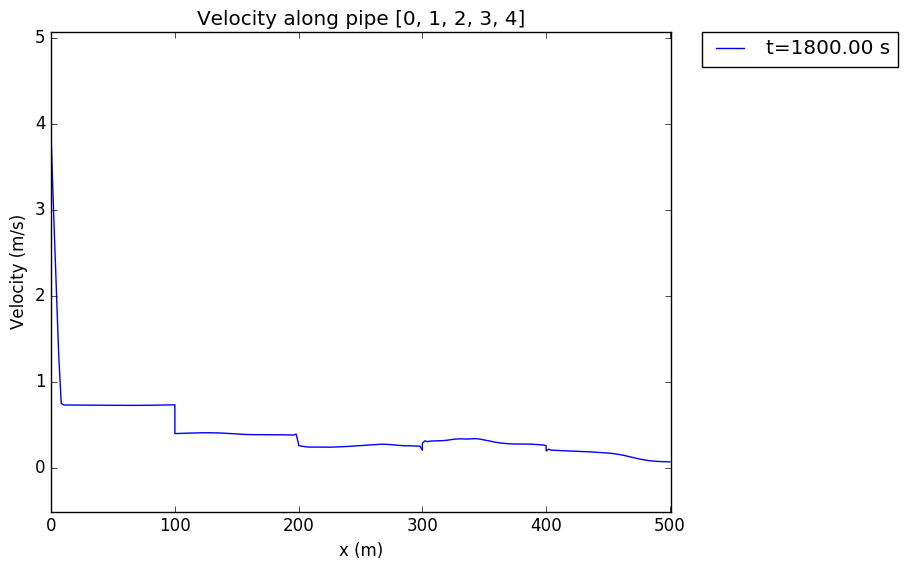

In [8]:
# the veolcity in pipe_interest changes with time ,dynamic picture
U_interest=[]
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
#M_total=Mi_draw*1+1
Mi_draw=3000
for m in range(0,M_total,Mi_draw) :
    U_interest_tfixed=[] 
    for i in range(len(pipe_interest)):
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Utemp=[]
        for k in range(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]
            AN=qh[idx_t(0,N,m,N)]
            Qk=qh[idx_t(1,k,m,N)]
            # when Q is actually very samll and its value is due to numerical oscillation, set it as 0
            if abs(Ak-AN)<0.1*A_pipe[i] and AN<0.1*A_pipe[i]:  
                Qk=0   
            vk = Qk/Ak                 
            Utemp.append(vk)
            #Utemp=[qh[idx_t(1,k,m,N)]/qh[idx_t(0,k,m,N)] for k in range(1,N+1)]
        U_interest_tfixed.append(Utemp)
    U_interest.append(U_interest_tfixed)
    U_interest_combine = np.concatenate(U_interest[int(m/Mi_draw)],axis =0)
    # plt.figure(figsize= (15,5))    #plot on different figures
    figsize= (15,5)                 #plot on the same figure
    pl.clf()
    pl.plot(x_interest_combine,U_interest_combine, lw = 1,label = 't=%.2f s'%(dt*m))
    '''
    #plt.figure(figsize= (15,5))
    for i in range(len(pipe_interest)):
        figsize(15,5)
        plot(x_interest[i],U_interest[int(m/Mi_draw)][i], lw = 1,  label = 'pipe %d, t=%.2f s'%(pipe_interest[i],dt*m))
        # m is time step, and should divide m/Mi_draw to get what we need
        #plot(x,Hx, lw = 1, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
    '''
    xlabel('x (m)')        
    ylabel('Velocity (m/s)')
    xlim(0,x_interest[-1][-1]+1)
    Umax=1.1*max(U_interest_combine)
    #ylim(-0.1,2.5)
    ylim(-0.5,1.2*Umax)
    #print int(m/Mi_draw)      #for test
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    title('Velocity along pipe %s'%str(pipe_interest))
    display.display(pl.gcf())
    display.clear_output(wait=True)
    #time.sleep(0.01)
    # print U_interest[5][1]   # first index is #*Mi timestep, second index is pipe # in pipe_interest list



<IPython.core.display.Javascript object>


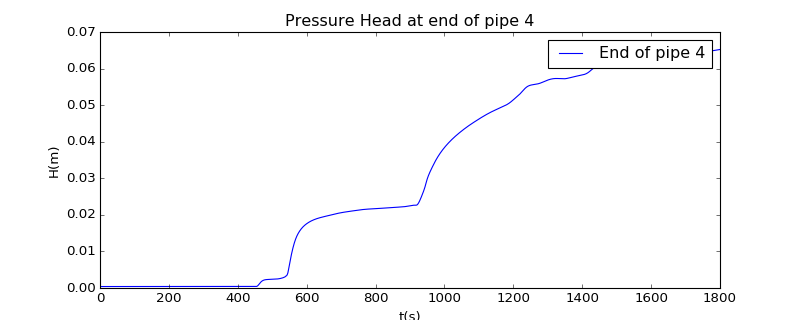

<IPython.core.display.Javascript object>


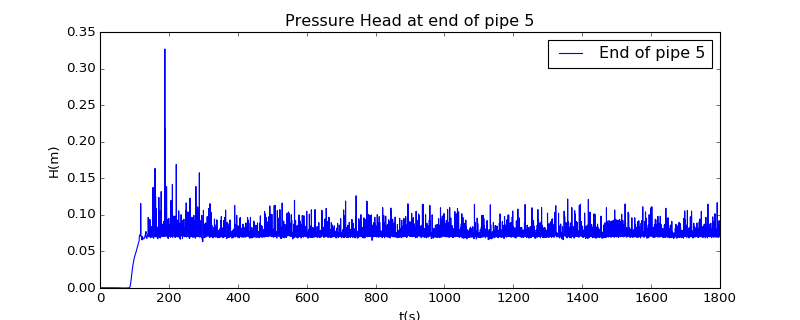

<IPython.core.display.Javascript object>


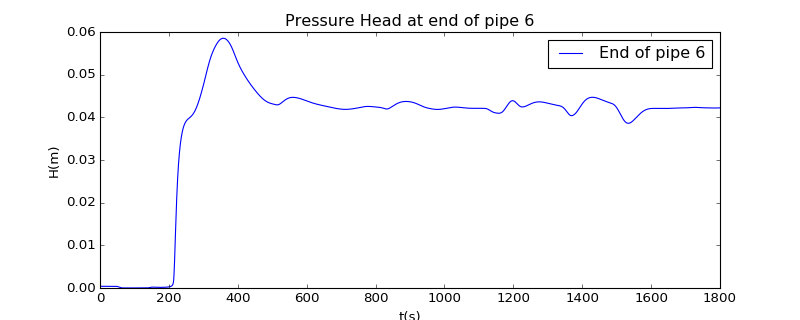

<IPython.core.display.Javascript object>


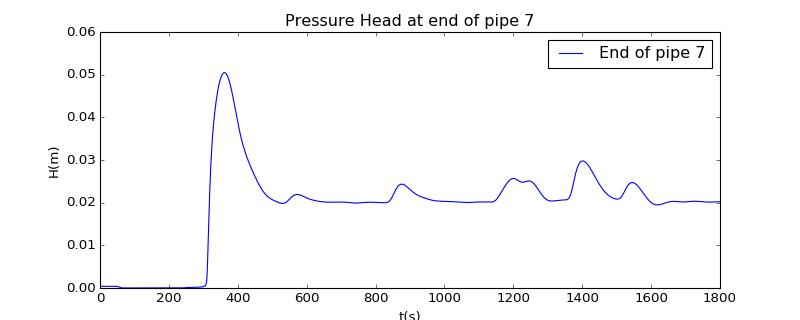

<IPython.core.display.Javascript object>


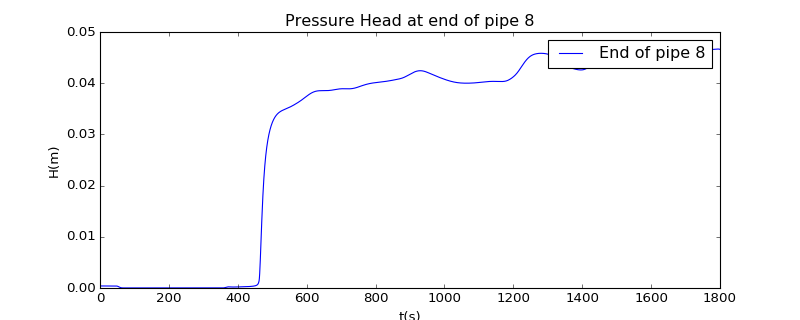

In [13]:
# Plot the Pressure head at the end of outflow pipes
t = linspace(0,n1.T,n1.M+1)
for i in xrange(1,len(jt)):
    if jt[i]==1:
        pipe_number=i-1
        Pend = n1.pressureTimeSeries(int(pipe_number),n1.Ns[pipe_number])
        Pstart=n1.pressureTimeSeries(int(pipe_number),1)
        #figsize=(15,5)
        #plt.figure(figsize= (10,4))
        #plt.plot(t,Pstart,label = "start of pipe %d" %(i-1))
        #legend()
        plt.figure(figsize= (10,4))                  # so that every time it can create a new figure
        plt.plot(t,Pend,label = "End of pipe %d" %(i-1))
        xlabel('t(s)')
        ylabel('H(m)')
        legend()
        title('Pressure Head at end of pipe %d'%pipe_number)

<IPython.core.display.Javascript object>


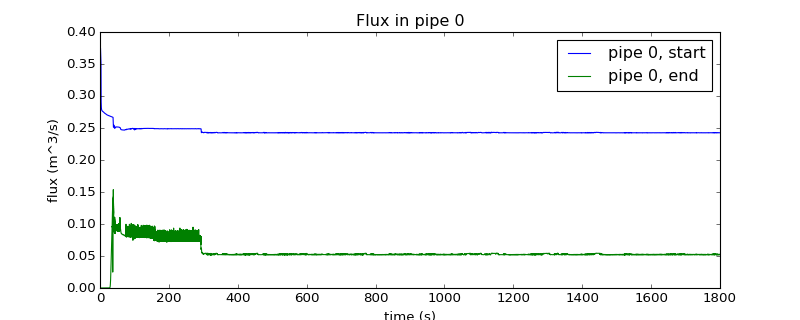

<IPython.core.display.Javascript object>


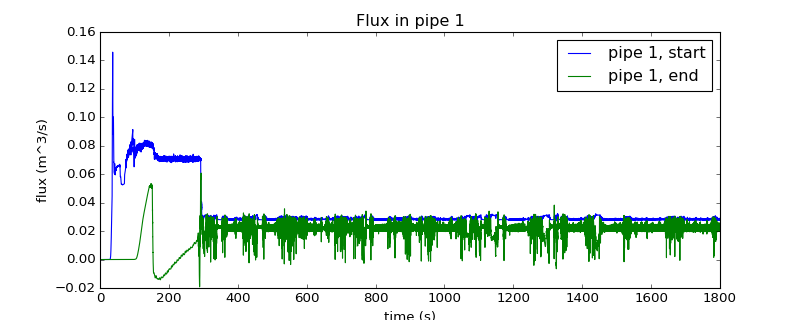

<IPython.core.display.Javascript object>


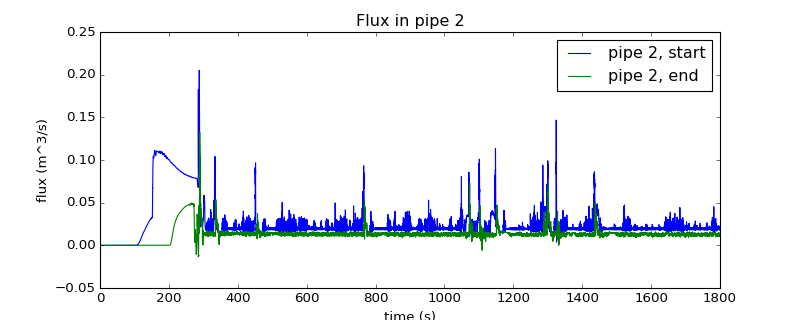

<IPython.core.display.Javascript object>


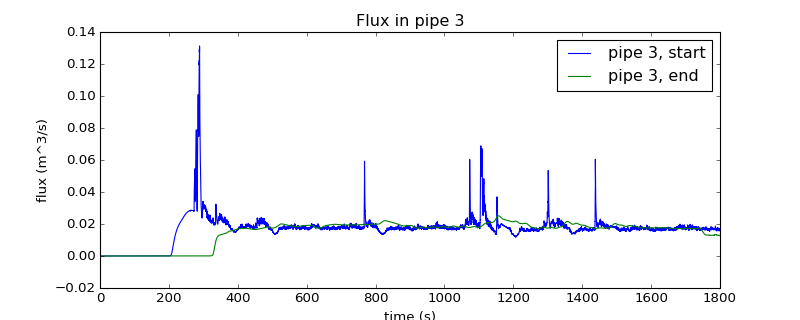

<IPython.core.display.Javascript object>


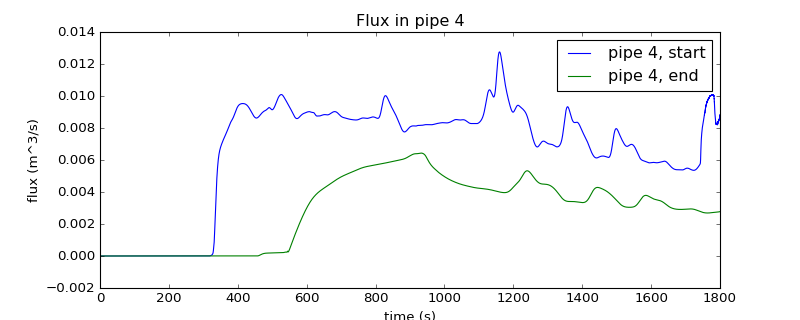

<IPython.core.display.Javascript object>


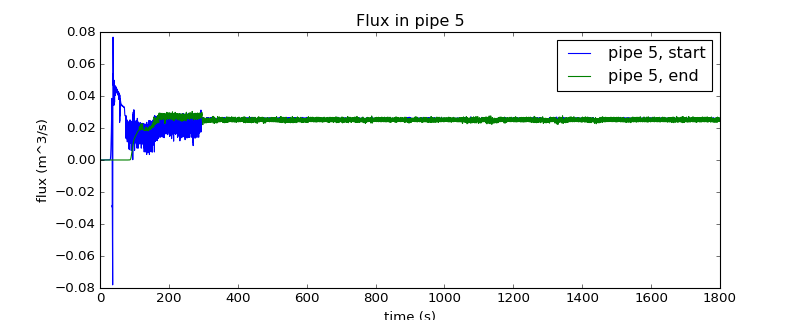

<IPython.core.display.Javascript object>


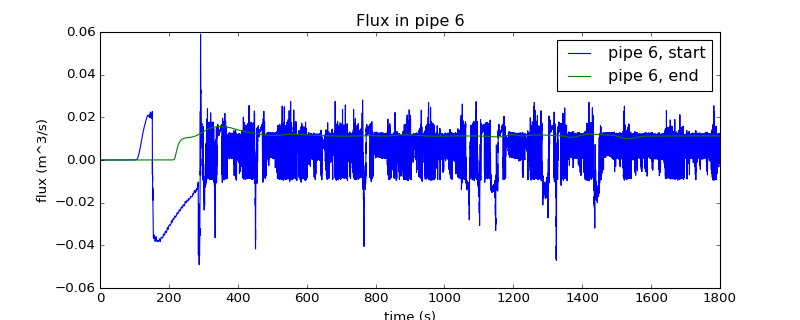

<IPython.core.display.Javascript object>


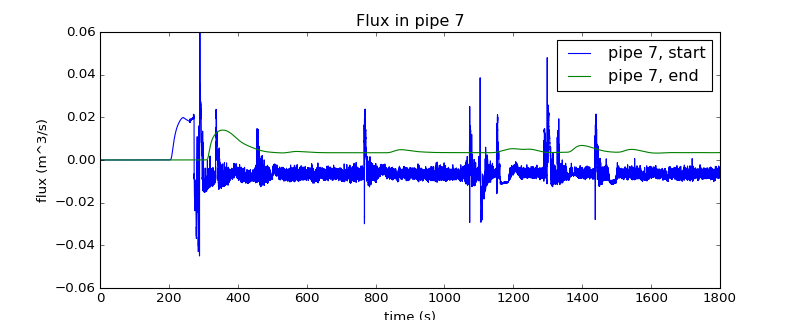

<IPython.core.display.Javascript object>


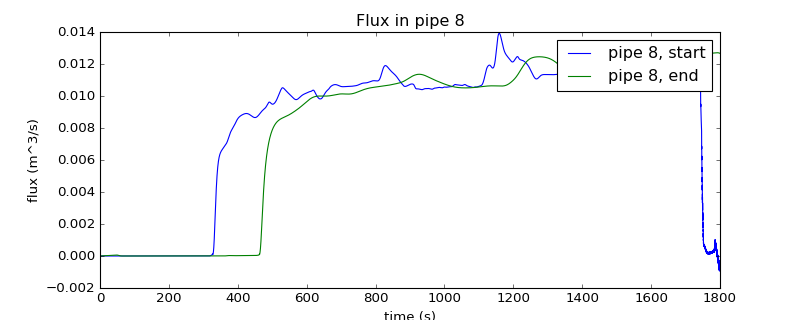

Pipe 0 during 1800 s have total flow: 439.715 m^3 (start node)
Pipe 0 during 1800 s have total flow: 100.372 m^3 (end node)
339.34312062
Pipe 1 during 1800 s have total flow: 61.947 m^3 (start node)
Pipe 1 during 1800 s have total flow: 34.937 m^3 (end node)
27.010253499
Pipe 2 during 1800 s have total flow: 46.747 m^3 (start node)
Pipe 2 during 1800 s have total flow: 24.043 m^3 (end node)
22.704025419
Pipe 3 during 1800 s have total flow: 30.356 m^3 (start node)
Pipe 3 during 1800 s have total flow: 26.982 m^3 (end node)
3.37388303552
Pipe 4 during 1800 s have total flow: 11.883 m^3 (start node)
Pipe 4 during 1800 s have total flow: 5.273 m^3 (end node)
6.61005764034
Pipe 5 during 1800 s have total flow: 45.194 m^3 (start node)
Pipe 5 during 1800 s have total flow: 41.698 m^3 (end node)
3.49654587469
Pipe 6 during 1800 s have total flow: 3.064 m^3 (start node)
Pipe 6 during 1800 s have total flow: 18.354 m^3 (end node)
-15.2893388735
Pipe 7 during 1800 s have total flow: -9.390 m^3 (

In [10]:
# Display the inflow and outflow for each pipe (m^3)
# Get Q of two ends of each pipe
Q = []
Mstep=1
#pipe_interest=[0]
pipe_interest=range(0,9)   
'''Here I redefine the pipe_interest vector'''

for i in range(len(pipe_interest)):
    Q_pipefix = [] 
    Q_start=[]
    Q_end=[]
    for m in xrange(0,n1.M,Mstep) :
        j = pipe_interest[i]
        N = n1.Ns[j]
        qh = n1.qhist(j)
        Q_start.append(qh[idx_t(1,1,m,N)])   # Q1
        Q_end.append(qh[idx_t(1,N,m,N)])     # QN
    Q_pipefix.append(Q_start)
    Q_pipefix.append(Q_end)
    Q.append(Q_pipefix)
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)
endorstart=['start','end']
for i in range(len(pipe_interest)):
    plt.figure(figsize= (10,4))                # same pipe on same figure
    for j in range(0,2):  
        #figsize = (15,5)                        # plot on same figure           
        #plt.figure(figsize= (15,5))             # plot on different figures
        plot(xt,Q[i][j], lw = 1,label = 'pipe %d, %s'%(pipe_interest[i],endorstart[j]))
        #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)   #legend will be placed out of box and cannot be shown
        legend()
        xlabel('time (s)')
        ylabel('flux (m^3/s)')
        title('Flux in pipe %d'%pipe_interest[i])

# calculate inflow and outflow, i means pipe number, j means start or end, time means time in vector  
delta_t=Mstep*dt
#Q_total=[]
for i in range(len(pipe_interest)):
    Q_total_pipefix=[]
    for j in range(0,2):
        Q_sum=0
        for time in range(len(Q[i][j])):
            Q_sum += Q[i][j][time]*delta_t
        Q_total_pipefix.append(Q_sum)
        print 'Pipe %d during %d s have total flow: %.3f m^3 (%s node)'%(pipe_interest[i],n1.T,Q_sum,endorstart[j])
    V_dif = Q_total_pipefix[0]- Q_total_pipefix[1]
    print V_dif
    #Q_total.append(Q_total_pipefix)                
   

<IPython.core.display.Javascript object>


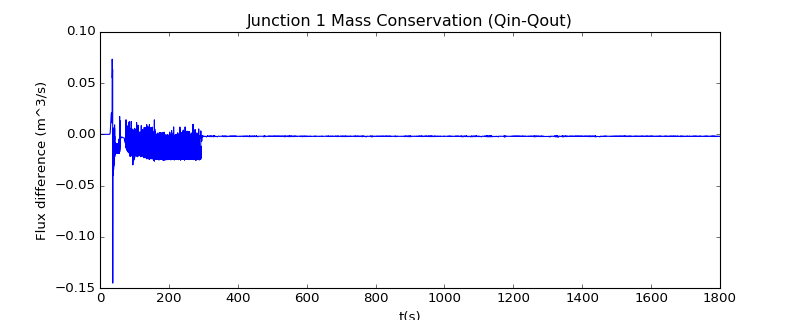

<IPython.core.display.Javascript object>


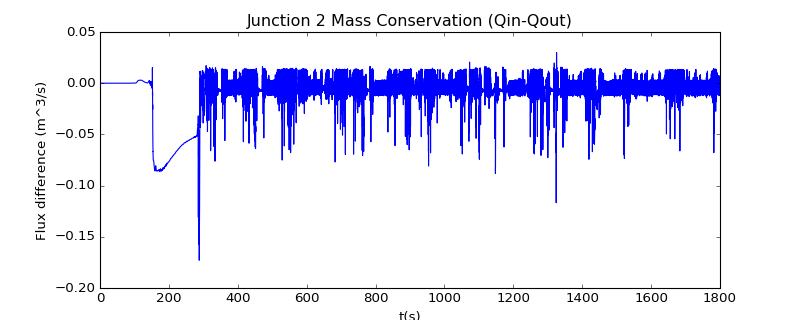

<IPython.core.display.Javascript object>


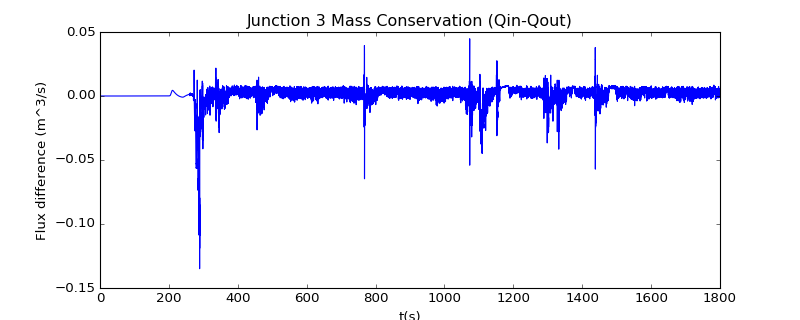

<IPython.core.display.Javascript object>


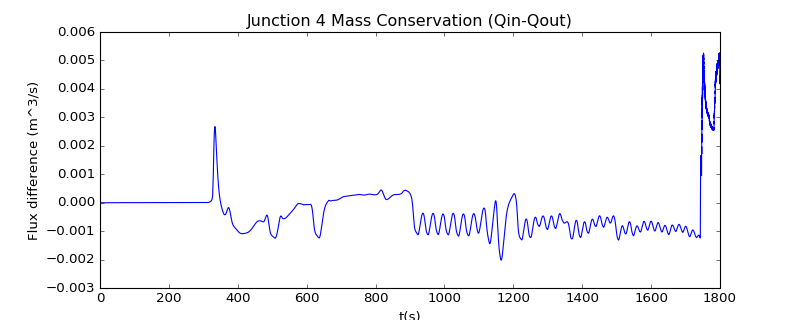

In [11]:
# Display mass balance for each junction

# Create x axis
xt = np.linspace(0, n1.M*dt, n1.M/Mstep)

#The following three list must corresponds to each other  
JunNode=[1,2,3,4]
Pipejun_in=[[0],[1],[2],[3]]
Pipejun_out=[[1,5],[2,6],[3,7],[4,8]]
assert (len(Pipejun_in)==len(Pipejun_out)),"Different dimensions of Pipejun_in and Pipejun_out!"

# Q[i][j][k]   i means pipe number, j means start or end, k means time in vector 
for i in xrange(len(Pipejun_in)):
    Qjun_dif = []
    for k in xrange(len(Q[0][1])):
        Qinflow = 0
        Qoutflow = 0
        for j1 in Pipejun_in[i]:
            Qinflow += Q[j1][1][k]
        for j2 in Pipejun_out[i]:
            Qoutflow += Q[j2][0][k]
        Qjun_dif.append(Qinflow-Qoutflow)
    plt.figure(figsize= (10,4)) 
    plot(xt,Qjun_dif)   
    xlabel('t(s)')
    ylabel('Flux difference (m^3/s)')
    title('Junction %d Mass Conservation (Qin-Qout)'%JunNode[i])


35.6552306445


<IPython.core.display.Javascript object>


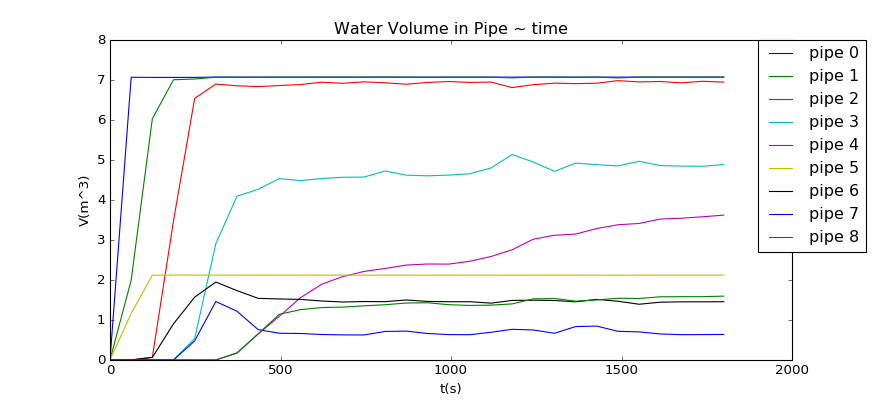

In [12]:
# Get A of two ends of each pipe
A = [] # all time, all pipes, all A values in grids
pipe_interest1=range(0,9)  
'''Here I redefine the pipe_interest vector'''

M_total=n1.M+1
Mi_draw=5000

for m in xrange(0,M_total,Mi_draw) :
    A_tfixed=[] # certain time, all pipes, all A values in grids
    for i in xrange(len(pipe_interest1)):
        j = pipe_interest1[i]
        N = n1.Ns[j]
        qh = n1.qhist(j) 
        Atemp=[]  #certain time, certain pipe, all A values in grids
        for k in xrange(1,N+1):
            Ak=qh[idx_t(0,k,m,N)]      
            Atemp.append(Ak)
        A_tfixed.append(Atemp)     
    A.append(A_tfixed)
        
#calculate total volumn, i means time, j means pipe number, distance means value of grids  
V_total=[]
for i in xrange(0,M_total,Mi_draw):
    V_total_tfix=[]
    for j in xrange(len(pipe_interest1)):
        V_sum=0
        pipe_number=pipe_interest1[j]
        delta_x=n1.Ls[pipe_number]/n1.Ns[pipe_number]
        for distance in xrange(len(A[int(i/Mi_draw)][j])):
            V_sum += A[int(i/Mi_draw)][j][distance]*delta_x
        V_total_tfix.append(V_sum)
        #print 'Pipe %d during %d s have total water volume: %.3f m^3 '%(pipe_number,i*dt,V_sum)
    #print 'The total volumn at t=%d s are                      %.3f m^3'%(i*dt,sum(V_total_tfix))
    V_total.append(V_total_tfix)
print n1.getTotalVolume()

xt1 = np.linspace(0, M_total*dt, M_total/Mi_draw)
plt.figure(figsize= (11,5))
title('Water Volume in Pipe ~ time')
xlabel('t(s)')
ylabel('V(m^3)')
for j in xrange(len(pipe_interest1)):
    pipe_number=pipe_interest1[j]
    V_total_pipefix=[]
    for i in xrange(1,M_total,Mi_draw):
        V_total_pipefix.append(V_total[int(i/Mi_draw)][j])
    plot(xt1,V_total_pipefix,label = 'pipe %d'%pipe_number)
    legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)


In [ ]:
# illustrate why v is not zero even when empty
def ShowQAofPipeEnd(pipe_detect,time_detect,total_time,total_timestep):
    timestep=int(time_detect/total_time*total_timestep)
    Q=n1.qhist(pipe_detect)[idx_t(1,n1.Ns[pipe_detect],timestep,n1.Ns[pipe_detect])]   #Q at middle of time, end of pipe 4
    A=n1.qhist(pipe_detect)[idx_t(0,n1.Ns[pipe_detect],timestep,n1.Ns[pipe_detect])]   #A at middle of time, end of pipe 4
    print 'At %ds, The Flux at the end of pipe %d is %.8f m^3/s, the water cross area is %.8f m^2 '%(time_detect,pipe_detect,Q,A)
    print 'The velocity is %.8f m/s'%(Q/A)
    
    
ShowQAofPipeEnd(4,1800,n1.T,n1.M)
    

In [ ]:
print Q_in*1800